In [1]:
from pathlib import Path
import json

import pandas as pd

data_path = Path("data/synthetic_incidents.json")
with data_path.open(encoding="utf-8") as handle:
    incidents = json.load(handle)

rows: list[dict[str, object]] = []
for item in incidents:
    measurement = item.get("sensor_measurement") or {}
    payload = measurement.get("payload") or {}
    row = {
        "severity": item.get("severity"),
        "sensor_type": measurement.get("type"),
        "sensor_status": measurement.get("status"),
    }
    for key, value in payload.items():
        row[f"payload_{key}"] = value
    rows.append(row)

df = pd.DataFrame(rows)
df.head()

,severity,sensor_type,sensor_status,payload_chlorine_ppm,payload_ph,payload_failed_attempts,payload_unique_ips,payload_anomaly_score,payload_pm2_5,payload_vehicle_count,payload_avg_speed_kmh
0,medium,Utilities,warning,0.73,7.44,NaN,NaN,NaN,NaN,NaN,NaN
1,high,Cybersecurity,alert,NaN,NaN,416.0,37.0,NaN,NaN,NaN,NaN
2,medium,Public Safety,alert,NaN,NaN,NaN,NaN,0.55,NaN,NaN,NaN
3,medium,Utilities,warning,1.59,7.88,NaN,NaN,NaN,NaN,NaN,NaN
4,medium,Utilities,healthy,1.16,6.71,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Prepare model features using only sensor-derived data
feature_columns = [column for column in df.columns if column != "severity"]
X = pd.get_dummies(df[feature_columns], drop_first=False)
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median())
y = df["severity"]

print(f"Feature matrix shape: {X.shape}")
print("Class distribution:")
print(y.value_counts())

Feature matrix shape: (1500, 16)
Class distribution:
severity
medium      529
high        423
low         345
critical    203
Name: count, dtype: int64


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 16, 24],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [1, 2],
}

search = GridSearchCV(
    RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample",
    ),
    param_grid=param_grid,
    scoring="f1_macro",
    n_jobs=-1,
    cv=5,
)
search.fit(X_train, y_train)
model = search.best_estimator_
print("Best parameters:", search.best_params_)
print(f"Best CV f1_macro: {search.best_score_:.3f}")

Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
Best CV f1_macro: 0.849


In [4]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.847

Classification report:
              precision    recall  f1-score   support

    critical       0.84      0.80      0.82        40
        high       0.84      0.76      0.80        85
         low       0.85      0.96      0.90        69
      medium       0.85      0.86      0.85       106

    accuracy                           0.85       300
   macro avg       0.85      0.84      0.84       300
weighted avg       0.85      0.85      0.85       300



In [5]:
import pandas as pd

importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importance[importance > 0].head(12).to_frame(name="importance")

,importance
payload_anomaly_score,0.158240
payload_pm2_5,0.139755
payload_avg_speed_kmh,0.121152
payload_failed_attempts,0.113033
sensor_status_alert,0.084150
payload_chlorine_ppm,0.077386
payload_vehicle_count,0.068854
payload_unique_ips,0.055504
payload_ph,0.052626
sensor_status_healthy,0.050523


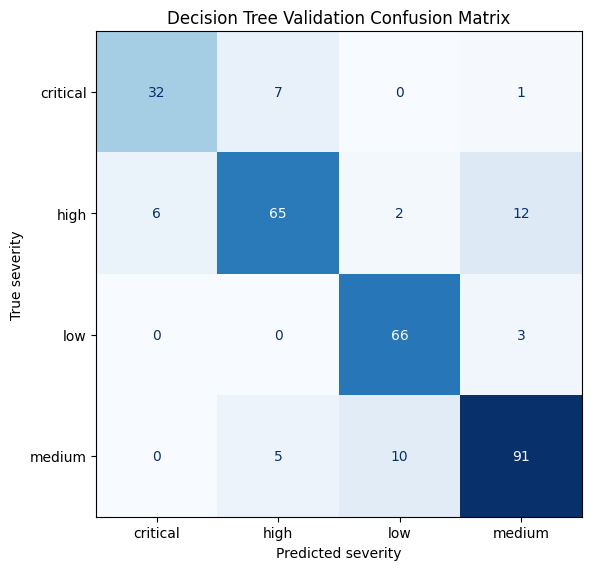

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=model.classes_,
    cmap="Blues",
    ax=ax,
    colorbar=False,
)
ax.set_title("Decision Tree Validation Confusion Matrix")
ax.set_xlabel("Predicted severity")
ax.set_ylabel("True severity")
plt.tight_layout()
plt.show()

In [7]:
fig.savefig("matrix")